In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return int(sum_x/length), int(sum_y/length)

def show_image_plt(image, json_file):
    point_polygon = np.array(json_file['shapes'][0]['points'], np.int32)
    x,y = centeroidnp(point_polygon)
    hsize = json_file['imageHeight']
    wsize = json_file['imageWidth']
    filename_img = json_file['imagePath']
        
    new_image  = cv2.polylines(image, [point_polygon], True ,(0, 0, 255), 3)
    new_image2 = cv2.circle(new_image, (x, y), 5, (0, 0, 255), 10)
    img_rgb = cv2.cvtColor(new_image2, cv2.COLOR_BGR2RGB)    
    
    plt.title(f'File: {filename_img} \n Centroid: {x,y} \n size {hsize,wsize}')
    plt.imshow(img_rgb)

In [1]:
import os
import cv2
import json

import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt


import os
import numpy as np
import torch
from PIL import Image
import torchvision
from torch.autograd import Variable

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
      

In [2]:
class PennFudanDataset():
    def __init__(self):

        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir('../data/TrainingSet/images')))
        self.centroids = list(sorted(os.listdir('../data/TrainingSet/json')))

    def __getitem__(self, idx):
        
        # load images and masks
        img_path = os.path.join('../data/TrainingSet', "images", self.imgs[idx])
        img = cv2.imread(f'{img_path}', cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)

        img_shape = img.shape
        img = torch.tensor(img)
        img = torch.reshape(img,(img_shape[2],img_shape[0],img_shape[1]))

        centroids_path = os.path.join('../data/TrainingSet', "json", self.centroids[idx])        
        json_uploaded = open(f'{centroids_path}','r')

        json_file = json.loads(json_uploaded.read()) 
        centroid = self.centroid(np.array(json_file['shapes'][0]['points'],np.int32))

        boxes = [centroid[0], centroid[1], 
                 json_file['imageWidth'], json_file['imageHeight']]

        boxes = torch.tensor(boxes)
        boxes = torch.reshape(boxes, (1, 4))

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((1,), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((1,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target['area'] = area
        target['image_id'] = torch.tensor([idx])
        target['iscrowd'] = iscrowd

        return img, target

    def centroid(self, arr):
        length = arr.shape[0]
        sum_x = np.sum(arr[:, 0])
        sum_y = np.sum(arr[:, 1])
        return int(sum_x/length), int(sum_y/length)    
    
    def __len__(self) -> int:
        return len(self.imgs)

In [3]:
dataset = PennFudanDataset()
dataset[0]

(tensor([[[ 12., 115.,  36.,  ..., 102.,  40.,  18.],
          [109.,  50.,  13.,  ...,  47.,  10.,  86.],
          [ 47.,  18.,  94.,  ...,   1.,  51.,  48.],
          ...,
          [100.,  36.,   9.,  ...,  53.,   9.,  89.],
          [ 54.,   4.,  84.,  ...,   7.,  57.,  46.],
          [  9., 112.,  29.,  ..., 112.,  48.,  11.]],
 
         [[110.,  45.,   5.,  ...,  47.,  12.,  92.],
          [ 57.,  12.,  92.,  ...,  15.,  62.,  52.],
          [  5., 110.,  26.,  ..., 105.,  40.,  12.],
          ...,
          [212., 172., 250.,  ...,   3.,  58.,  52.],
          [  5., 106.,  26.,  ..., 108.,  45.,  24.],
          [120.,  57.,   9.,  ..., 219., 166., 246.]],
 
         [[211., 171., 249.,  ...,   5.,  58.,  50.],
          [  5., 106.,  28.,  ..., 100.,  37.,   7.],
          [106.,  42.,   3.,  ..., 201., 165., 245.],
          ...,
          [  8., 106.,  29.,  ..., 111.,  50.,   8.],
          [106.,  45.,   7.,  ...,  50.,  13.,  89.],
          [ 50.,   7.,  83.,  .

In [4]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [5]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [7]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [15]:
# use our dataset and defined transformations
dataset = PennFudanDataset()
dataset_test = PennFudanDataset()

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(113).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-34])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-34:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size= 1, shuffle = False, num_workers=1,
    collate_fn = collate_fn)

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0005, weight_decay=0.00005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

num_epochs = 1

In [17]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, target in data_loader:
      images = list(image.to(device) for image in images)
      target = [{k: v.to(device) for k, v in t.items()} for t in target]
      loss_dict = model(images, target)
      
      print(loss_dict)

      losses = sum(loss for loss in loss_dict.values())
      loss_value = losses.item()

      loss_hist.send(loss_value)

      optimizer.zero_grad()
      losses.backward()
      optimizer.step()

      if itr % 2 == 0:
          print(f"Iteration #{itr} loss: {loss_value}")

      itr += 1
    lr_scheduler.step()
    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

RuntimeError: DataLoader worker (pid(s) 3916) exited unexpectedly

In [60]:
images, targets = dataset[0]
boxes = targets['boxes'].cpu().numpy().astype(np.int32)
sample = images.numpy()[0]
print(images.size())

torch.Size([3, 879, 1000])


In [61]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(torch.reshape(images, (1, 3, images.size()[1], images.size()[2])))
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

print(outputs)
boxes = outputs[0]['boxes']

[{'boxes': tensor([[5.4788e+02, 2.6769e+02, 1.0000e+03, 8.5818e+02],
        [3.0304e+02, 2.1893e+02, 1.0000e+03, 5.7839e+02],
        [2.3202e+02, 3.5527e+02, 1.0000e+03, 7.0949e+02],
        [1.4195e+02, 2.8056e+02, 8.1903e+02, 8.6018e+02],
        [1.5185e+02, 8.5809e+01, 1.0000e+03, 4.4963e+02],
        [2.3783e+02, 5.5995e+02, 1.0000e+03, 8.6818e+02],
        [5.0583e+01, 6.6277e+01, 7.7086e+02, 7.3226e+02],
        [5.2132e+02, 9.8010e-01, 1.0000e+03, 6.7584e+02],
        [0.0000e+00, 2.4953e+02, 4.3686e+02, 8.6268e+02],
        [3.5170e+02, 0.0000e+00, 8.5949e+02, 6.0532e+02]],
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'scores': tensor([0.1138, 0.1116, 0.1084, 0.1076, 0.1007, 0.0976, 0.0959, 0.0765, 0.0719,
        0.0706], grad_fn=<IndexBackward>)}]


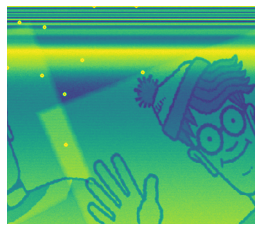

In [70]:
plt.axis('off')

for box in boxes:
    x = int(box[0].detach().numpy())
    y = int(box[1].detach().numpy())
    sample = cv2.circle(sample, (x, y), 5, (255, 0, 0), 5)
    
plt.imshow(sample)

In [71]:
cvsample

array([[237., 237., 237., ..., 236., 236., 229.],
       [229., 229., 232., ..., 234., 236., 236.],
       [236., 239., 239., ..., 233., 233., 233.],
       ...,
       [214., 214., 214., ..., 212., 212., 216.],
       [216., 216., 204., ..., 154., 144., 144.],
       [144., 185., 185., ..., 217., 217., 217.]], dtype=float32)

(879, 1000, 3)


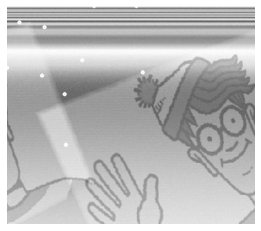

In [78]:
img = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB).astype(np.int32)
plt.axis('off')
plt.imshow(img)

In [ ]:

def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset()
dataset_test = PennFudanDataset()

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-34])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-34:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1,
                                               shuffle = False, num_workers = 4,
                                               collate_fn = utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
print(len(params))
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

84


In [ ]:
# let's train it for 10 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, 
                    data_loader, device, 
                    epoch, print_freq = 10)

    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AttributeError: ignored

In [90]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py /content/drive/MyDrive/WheresWally/src/
cp references/detection/transforms.py /content/drive/MyDrive/WheresWally/src/
cp references/detection/coco_eval.py /content/drive/MyDrive/WheresWally/src/
cp references/detection/engine.py /content/drive/MyDrive/WheresWally/src/
cp references/detection/coco_utils.py /content/drive/MyDrive/WheresWally/src/

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version
